# Signal from Hidden Markov Models (regime detection)

### Import

In [1]:
from __future__ import print_function

import datetime
import warnings

from pathlib import Path 

from hmmlearn.hmm import GaussianHMM
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
import numpy as np
import pandas as pd
import seaborn as sns

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Get data

In [2]:
filepath = Path('../../data/csv/Binance_BTCUSDT_1h.csv')

In [3]:
def format_datetime(date):
    if date[-2:] == 'AM':
        hour = int(date[-5:-3])
        year, month, day = date[:-6].split('-')
        date = pd.Timestamp(int(year), int(month), int(day), hour)
    elif date[-2:] == 'PM':
        hour = (int(date[-5:-3])+12)%24
        year, month, day = date[:-6].split('-')
        date = pd.Timestamp(int(year), int(month), int(day), hour)
    return date



def obtain_prices_df(csv_filepath, crop, nb_days):
    """
    Obtain the prices DataFrame from the CSV file, filter by the end date and calculate the REALIZED VOLATILITY.
    """
    df = pd.read_csv(csv_filepath)
    
    if crop:
        df = df[-nb_days*24:]
    
    df = df[::-1].reset_index().drop(columns=['index', 'unix', 'tradecount', 'symbol', 'open', 
                                              'high', 'low', 'Volume BTC', 'Volume USDT'])

    df["Realized_Vol"] = (((df["close"].pct_change())**2).rolling(24).sum())
    df = df.dropna().reset_index().drop(columns=['index']).set_index('date')

    # Scaling
    df["Realized_Vol"] = df["Realized_Vol"] / df["Realized_Vol"][0]
    
    # Reformat index - datetime
    df['date'] = df.apply(lambda row: format_datetime(row.name),axis=1)
    df = df.set_index('date')
    
    return df

In [4]:
BTC = obtain_prices_df(filepath, False, 10) # last two parameters are not important (just when I did some tests)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})


In [5]:
display(BTC.tail(3))
display(BTC.head(3))

,close,Realized_Vol
date,,
2022-04-16 22:00:00,40405.86,0.080685
2022-04-16 23:00:00,40378.71,0.079054
2022-04-17 00:00:00,40376.49,0.079038


,close,Realized_Vol
date,,
2017-08-18 04:00:00,4287.92,1.000000
2017-08-18 05:00:00,4313.56,1.014009
2017-08-18 06:00:00,4279.46,1.038321


In [6]:
df_train = BTC[BTC.index < '20200401']
df_output = BTC[BTC.index >= '20200401']

display(df_train.shape[0])
display(df_output.shape[0])

22960

17888

### Train model

Create the Gaussian Hidden markov Model and fit it to the BTC realized_volatility data

In [7]:
Realized_Vol = np.column_stack([df_train["Realized_Vol"]])

In [8]:
hmm_model = GaussianHMM(n_components=2, covariance_type="full", n_iter=1000).fit(Realized_Vol)
print("Model Score:", round(hmm_model.score(Realized_Vol),2))

Model Score: -18647.39


Create a visualizer to plot the detected regimes on the train set

In [9]:
def plot_in_sample_hidden_states(hmm_model, df):
    """
    Plot the adjusted closing prices masked by the in-sample hidden states as a mechanism to understand the market regimes.
    """
    #df = df.reset_index().drop(columns = ['date'])
    
    # Predict the hidden states array with the already trained HMM
    hidden_states = hmm_model.predict(Realized_Vol)
    
    # Plot the sub-regimes
    fig, axs = plt.subplots(hmm_model.n_components, sharex=True, sharey=True)
    colours = cm.rainbow(np.linspace(0, 1, hmm_model.n_components))
    
    for i, (ax, colour) in enumerate(zip(axs, colours)):
        mask = hidden_states == i
        ax.plot_date(
            df.index[mask], 
            df["Realized_Vol"][mask], 
            ".", linestyle='none', 
            c=colour
        )
        ax.set_title("Hidden State #%s" % i)
        ax.grid(True)
        
    plt.show()

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be r

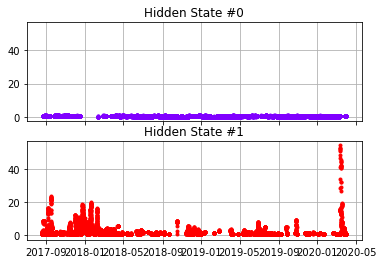

In [10]:
plot_in_sample_hidden_states(hmm_model, df_train)

### Predict signal

In [11]:
Realized_Vol_test = np.column_stack([df_output["Realized_Vol"]])

predicted_regimes = hmm_model.predict(Realized_Vol_test)

In [12]:
pd.Series(predicted_regimes).value_counts()

0    13842
1     4046
dtype: int64

In [13]:
df_signal = pd.DataFrame(predicted_regimes, index=df_output.index, columns=['HMM_detected_regime'])
df_signal.head(3)

,HMM_detected_regime
date,
2020-04-01 12:00:00,1
2020-04-01 01:00:00,0
2020-04-01 02:00:00,0


### Save signal

In [14]:
filepath = Path('../csv/signals_HMM_regime_detection.csv')

In [15]:
df_signal.to_csv(filepath)

## What to do next:
- see what we can do to optimize the HMM training